Спочатку треба розбити датасет на train, validation, test. Для цього будемо обирати останній запис з кожного користувача. Я розділю датасет на дві частини: користувачі з >3 записів, користувачі з 3 і менше записів. Так як в тестовому датасеті у нас є користувачі з дуже малою кількістю записів, буде цікаво перевірити, як добре працює у нас zero-shot learning. Тобто в validation set підуть три останні записи користувача, і для тих, у кого 3 і менше записів це буде означати, що модель взагалі на них не тренується. Але це добре, бо ми перевіримо якість моделі для zero-shot learning.

In [1]:
# read data
import pandas as pd

path_to_train = './data/train.csv'
train = pd.read_csv(path_to_train, encoding='utf-8', usecols=['ts_listen', 'user_id', 'listen_type'])
train['index'] = train.index

In [2]:
train = train.sort_values(by='ts_listen', axis=0)
train.head()

,ts_listen,listen_type,user_id,index
5010516,1,0,4606,5010516
1309460,2,0,7557,1309460
824607,2,0,5034,824607
5321927,2,0,13875,5321927
5010515,3,0,4606,5010515


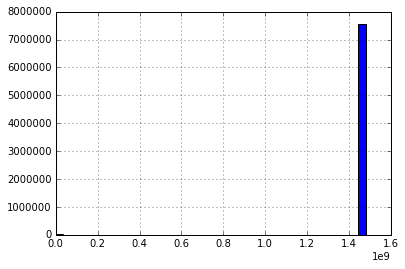

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

train["ts_listen"].hist(bins=40)

In [4]:
len(train[train["ts_listen"] < 1000000000])

631

Випадково побачив, що у деяких користувачів битий ts_listen, котрий має бути дуже великий. Честно - і фіг з ними. Всього 631 таких записів.

In [3]:
test = train[train['listen_type'] == 1].groupby(['user_id']).last()
test.head()

,ts_listen,listen_type,index
user_id,,,
0,1480614172,1,3613097
1,1480460343,1,2341766
2,1480529088,1,7315223
3,1480628912,1,4413990
4,1480524236,1,1316978


In [11]:
test.loc[6]['ts_listen']

1479800973

In [12]:
7 in test.index

False

In [5]:
test['index'].head()

user_id
0    3613097
1    2341766
2    7315223
3    4413990
4    1316978
Name: index, dtype: int64

In [14]:
train[train['user_id']==1000]

,ts_listen,listen_type,user_id,index
5277643,1477919203,0,1000,5277643
2258870,1477960447,0,1000,2258870
263218,1477960646,0,1000,263218
2258871,1477960653,0,1000,2258871
2392009,1477960654,0,1000,2392009
7126906,1477996347,0,1000,7126906
4553937,1477996594,0,1000,4553937
1660394,1477996599,0,1000,1660394
4576699,1477996848,0,1000,4576699
5752300,1477997203,0,1000,5752300


In [6]:
len(test)

15971

Тепер я просто зберу це в лібу

Я забув про один момент. Валідацію варто робити не просто на останніх значеннях. Її варто робити на останнії значеннях з Flow. І якщо після них є ще записи не з Flow - відкидати їх.

In [19]:
test.loc[1]

ts_listen      1480460343
listen_type             1
index             2341766
Name: 1, dtype: int64

In [17]:
ls = []
for user_id,group in train.groupby('user_id'):
    if(user_id in test.index):
        ls.append(group[group['ts_listen'] > test.loc[user_id]['ts_listen']]['index'])
future_indexes = [index for index_ls in ls for index in index_ls]
train.loc[future_indexes]

,ts_listen,listen_type,user_id,index
1372379,1480504472,0,1,1372379
3832898,1480504631,0,1,3832898
4631871,1480504868,0,1,4631871
1088870,1480505070,0,1,1088870
6579222,1480505253,0,1,6579222
6327406,1480505466,0,1,6327406
5976642,1480505712,0,1,5976642
2052810,1480505887,0,1,2052810
401886,1480506073,0,1,401886
6107878,1480506294,0,1,6107878


Нічого так данних відфільтрувалося... 